In [1]:
%%capture
!apt install python3-dev graphviz libgraphviz-dev pkg-config
!pip install pywhy-graphs
!pip install networkx pygraphviz matplotlib

In [2]:
import networkx as nx
from networkx import Graph, DiGraph
from networkx.drawing.nx_agraph import graphviz_layout

import pywhy_graphs as pg
import pywhy_graphs.viz as viz

from collections import deque

import matplotlib.pyplot as plt
from typing import List, Set, Tuple

# Introduction

Graphical causal models help represent and analyze causal relationships. D-separation allows us to find out whether a set X of variables is independent of another set Y, given a third set Z in a causual graph. D-separation helps identify the probability distributions that align with a given DAG. This is crucial for testing whether a causal model matches the observed data. If the model is inconsistent with the data, any conclusions drawn from it would be unreliable.

The paper we are implementing in this notebook introduces linear-time algorithms for testing and finding minimal d-separators in DAGs and other graph types. It is an impovement compared to previous methods that required quadratic time. Minimal separating sets are important for applications such as identifying minimal covariate adjustment sets or conditional instrumental variables.


We will describe implemented algorithms along the way for consistency.

# Implementation

First, let's implement the algorithms for DAGs, as they are simpler and are the main focus of the article. After, we will introduce algorithms for more general types of graphs.

### Algorithm for DAGs

To find a minimal d-separator between sets X and Y we can limit the search space only to the set {X | Y | I} and its ancestors. I is set of mandatory nodes that must always be included in the d-separating set Z.

In [3]:
# Define the function to compute ancestors
def ancestors(G: DiGraph, S: Set[str]) -> Set[str]:
  """Compute the set of ancestors in G for a given set of nodes S

    Parameters:
      G (DiGraph): A directed acyclic graph.
      S (Set[str]): A set of nodes in the graph.

    Returns:
      Set[str]: The set of ancestors of the nodes in S.
    """
  An_S = {an_s for s in S for an_s in nx.ancestors(G, s)}
  return An_S

Given a set A = An{X | Y | I} | {X | Y | I} we can calculate the closure of a given set. Closure of X is the set of all nodes V for which
there exists a path from X to V that only contains
nodes of A and no non-collider in Z.  (**Remark**: In the paper, A is defined as An{X | Y | I}. However, even though not explicitly stated in the paper, we believe that the set  {X | Y | I} should be included in A. These nodes are relevant for the closure computation. In any case it does not change the logic of the algorithm or the correctness of the minimality criterion).


To compute the closure modified rules for Bayes-Ball are introduced. According to these rules the pass is allowed if V is not in Z (even if V is a collider) or if V is a collider in Z.

In [4]:
def bayess_ball_pass_DAG(e, V, f, N, A, Z):
  """
  Determines whether the Bayes Ball can pass through a given node in a DAG.

  Parameters:
      e (str): The direction of the entering edge ("in" or "out").
      V (str): The current node being evaluated.
      f (str): The direction of the exiting edge relative to the neighbour ("in" if V->N or "out" if V<-N).
      N (str): The neighbor node of V.
      A (Set[str]): The set of nodes that restrict Bayes Ball movement,
      the ball cannot pass to nodes outside this set.
      Z (Set[str]): The separator.

  Returns:
      bool: True if the Bayes Ball can pass, False otherwise.
  """
  in_a = N in A
  V_not_in_Z = V not in Z
  is_collider = (e == "in" and f == "out")
  return in_a and (V_not_in_Z or is_collider)


def reachableDAG(G: DiGraph, X: Set[str] = set(),
                 A: Set[str] = set(), Z: Set[str] = set()):
  """
  Calculates the closure of a set X.

  Parameters:
      G (DiGraph): A directed acyclic graph.
      X (Set[str]): The set of nodes the closure of which is calculated.
      A (Set[str]): The set of nodes that restrict the closure,
      the closure cannot have nodes outside this set.
      Z (Set[str]): The separator.

  Returns:
      Set[str]: Closure of X.
  """

  # define the queue of pairs (type of edge, node) to visit.
  Q = deque([])
  # start with Q = {(←, X) | X ∈ X }.
  for node in X:
      Q.append(("out", node)) # here it doesn't matter what edge, since X is not in Z, it will pass in any case

  P = Q.copy()

  while any(Q):
    e, V = Q.popleft()
    # find neighbours of V and their edge types.
    edge_node_pairs = [("out", N) for N in G.pred[V]] + [("in", N) for N in G.succ[V]]
    for f, N in edge_node_pairs:
        # if the Bayess ball can pass to the neighbour, add it to the queue.
        # here it is very important that the way we assign e and f is consistent
        # with the way the are processed by Bayess Ball function
        if (f, N) not in P and bayess_ball_pass_DAG(e=e, V=V, f=f, N=N, A=A, Z=Z):
            Q.append((f, N))
            P.append((f, N))

  return {w for (_, w) in P}

Now we can calculate the minimal d-separator. If the separator is found it follows the minimality criterion. Removing any node from a minimal d-separator will turn it into non-separator.

In [5]:
def findminsepinDAG(G: DiGraph, X: Set[str] = set(), Y: Set[str] = set(),
                    I: Set[str] = set(), notR: Set[str] = set()):
  """
  Finds a minimal d-separator in a directed acyclic graph.

  Parameters:
      G (DiGraph): A directed acyclic graph.
      X (Set[str]) and Y (Set[str]): The set of nodes to be separated.
      I (Set[str]): Nodes that must always be included in the separator.
      notR (Set[str]): Nodes that must not be included in the separator.

  Returns:
      Set[str] or None: The minimal d-separator as a set of nodes or None if no separator exists.
  """
  R = set(G.nodes) - notR # nodes allowed to be in a separator
  XYI = X | Y | I
  A = ancestors(G, XYI) | XYI
  Z_init = R & (A - (X | Y)) # initial separator
  X_closure = reachableDAG(G, X, A, Z_init) # closure of X given the initial separator
  if X_closure & Y:
    return None  # no d-separator exists if X and Y are connected

  Z_updated = Z_init & (X_closure | I)

  Y_closure = reachableDAG(G, Y, A, Z_updated) # closure of Y given the updated separator

  return Z_updated & (Y_closure | I)


### Tests for DAG

In [6]:
# Define the fucntion for a beatifull plot (taken from the practicals)
def draw(G, inend: Tuple[Set[str], Set[str]] = (set(), set()),
         unobs: Set[str] = set(), Z: Set[str] = set()):
    plt.figure()
    pos = graphviz_layout(G, prog="dot")
    start_nodes, end_nodes = inend
    for v in G.nodes():
        node_color = "white"
        # Determine the color based on the node's category
        if v in start_nodes:
            node_color = "#A8D5BA"  # Starting nodes
        elif v in end_nodes:
            node_color = "#F7A1A1"  # Ending nodes
        elif v in Z:
            node_color = "dimgray"
        elif v in unobs:
            node_color = "lightyellow"
        nx.draw_networkx_nodes(
            G,
            pos=pos,
            nodelist=[v],
            node_color=node_color,
            node_shape="o",
            node_size=6e2,
            edgecolors="black",
            margins=0.2
        )
    nx.draw_networkx_labels(G, pos=pos, font_size=12)
    for e in G.edges():
        width = 1.0
        edge_color = "black"
        nx.draw_networkx_edges(
            G,
            pos=pos,
            edgelist=[e],
            edge_color=edge_color,
            width=width,
            arrowsize=15,
        )

In [8]:
# DAGs (these two examples are taken from the paper)
G1 = DiGraph([("X", "V2"), ("V2", "V3"), ("V3", "Y"), ("V1", "X"), ("V1", "V2")])
G2 = DiGraph([("V1", "X"), ("V1", "V2"), ("U", "X"), ("U", "V2"), ("V3", "V2"), ("V2", "Y"), ("V3", "Y")])

Minimal d-separator:  {'V2'}


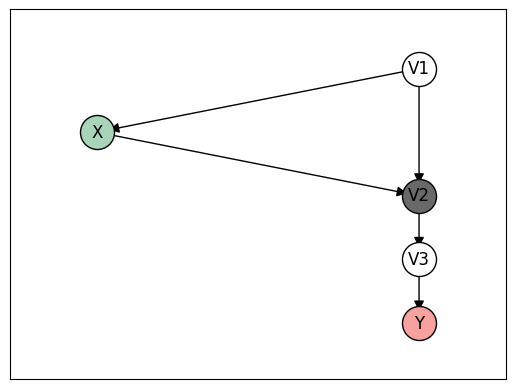

In [9]:
start_nodes = {"X"}
end_nodes = {"Y"}
minsepG1 = findminsepinDAG(G1, X=start_nodes, Y=end_nodes)
print("Minimal d-separator: ", minsepG1)
draw(G1, inend=(start_nodes, end_nodes), Z=minsepG1)

Minimal d-separator:  {'V2', 'V3'}


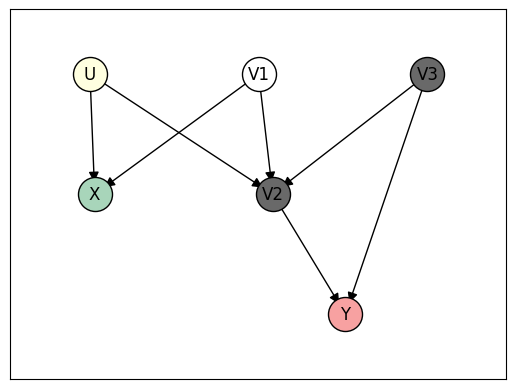

In [10]:
start_nodes = {"X"}
end_nodes = {"Y"}
unobs = {"U"}
minsepG2 = findminsepinDAG(G2, X=start_nodes, Y=end_nodes, notR=unobs)
print("Minimal d-separator: ", minsepG2)
draw(G2, inend=(start_nodes, end_nodes), unobs=unobs, Z=minsepG2)

The results are consistent with the ones provided in the paper.

### General algorithm

Unfortunately networkx does not allow graphs with both directed and undirected edges.
To work with more general types of graphs we are using [pywhy_graphs](https://github.com/py-why/pywhy-graphs). It is a Python graph library that extends networkx with the notion of a MixedEdgeGraph to implement a light-weight API for causal graphical structures that contain mixed-edges and contain causal graph traversal algorithms. The syntax of pywhy_graphs is very similar to networkx, so everything should be clear.

##### Plot of a mixed graph

In [11]:
def draw_mixed_graph(G_mixed, inend: Tuple[Set[str], Set[str]] = (set(), set()),
                     unobs: Set[str] = set(), Z: Set[str] = set()):
    plt.figure()
    pos = nx.spring_layout(G_mixed)
    start_nodes, end_nodes = inend

    # Node colors
    node_colors = []
    for v in G_mixed.nodes():
        if v in start_nodes:
            node_colors.append("#A8D5BA")
        elif v in end_nodes:
            node_colors.append("#F7A1A1")
        elif v in Z:
            node_colors.append("dimgray")
        elif v in unobs:
            node_colors.append("lightyellow")
        else:
            node_colors.append("white")
    nx.draw_networkx_nodes(
        G_mixed,
        pos=pos,
        node_color=node_colors,
        node_shape="o",
        node_size=600,
        edgecolors="black",
        margins=0.2
    )
    nx.draw_networkx_labels(G_mixed, pos=pos, font_size=12)
    nx.draw_networkx_edges(
        G_mixed.get_graphs(edge_type="directed"), pos=pos,
        edge_color="blue", arrowsize=10, min_target_margin=12, label="Directed"
    )
    for u, v in G_mixed.get_graphs(edge_type="bidirected").edges():
        plt.gca().annotate("", xy=pos[v], xytext=pos[u],
                           arrowprops=dict(arrowstyle="->", color="green", shrinkA=12, shrinkB=12))
        plt.gca().annotate("", xy=pos[u], xytext=pos[v],
                           arrowprops=dict(arrowstyle="->", color="green", shrinkA=12, shrinkB=12))
    nx.draw_networkx_edges(
        G_mixed.get_graphs(edge_type="undirected"), pos=pos,
        edge_color="red", label="Undirected"
    )
    plt.legend(
        handles=[
            plt.Line2D([0], [0], color="blue", lw=2, label="Directed"),
            plt.Line2D([0], [0], color="green", lw=2, label="Bidirected"),
            plt.Line2D([0], [0], color="red", lw=2, label="Undirected")
        ],
        loc="upper left"
    )

    plt.show()

A graph is an AG, if and only if (1) for any edge
A ← B or A ↔ B, A is not an anterior of B, and (2) for
any edge A −− B, there are no edges A ← C, A ↔ C,
B ← C or B ↔ C. The graph defined below as AG is slightly modified graph taken from RICHARDSON, T., AND SPIRTES, P. Ancestral
graph Markov models. Annals of Statistics 30
(2002), 927–1223. The graph defined as RCG is taken from VAN DER ZANDER, B., AND LISKIEWICZ, M.
Separators and Adjustment Sets in Markov Equivalent DAGs. In Proc. 30th AAAI Conf. on Artificial
Intelligence (2016), pp. 3315–3321.

A graph is a restricted chain graph iff (0) it
contains no ↔ edges (1) it contains no possibly directed
cycle that contains at least one directed edge (2) for each
triple A → B −− C, there is an edge between A and
C, and (3) every undirected component is chordal.

Every DAG is RCG and AG, every CPDAG is RCG.

Let's define a couple of graphs to test our algorithms. However we should note that for a proper test we need much more examples.

In [12]:
# create an AG for testing

directed_G = nx.DiGraph([("X", "V1"), ("V1", "V2"), ("V3", "Y")])
bidirected_G = nx.Graph([("V2", "Y")])
undirected_G = nx.Graph([("X", "V3")])

# add nodes to ensure all graphs have the same set of nodes
directed_G.add_nodes_from(["X", "V1", "V2", "Y"])
bidirected_G.add_nodes_from(["X", "V1", "V2", "Y"])
undirected_G.add_nodes_from(["X", "V1", "V2", "Y"])

# create the AG
AG = pg.networkx.MixedEdgeGraph(
    graphs=[directed_G, bidirected_G, undirected_G],
    edge_types=["directed", "bidirected", "undirected"],
)

In [13]:
# create CPDAG

directed_G = nx.DiGraph([("X", "V2"), ("V1", "Y"), ("V2", "Y")])
bidirected_G = nx.Graph([])
undirected_G = nx.Graph([("V2", "V3"), ("X", "V1")])

all_nodes = ["X", "Y", "V1", "V2", "V3"]
directed_G.add_nodes_from(all_nodes)
bidirected_G.add_nodes_from(all_nodes)
undirected_G.add_nodes_from(all_nodes)

CPDAG = pg.networkx.MixedEdgeGraph(
    graphs=[directed_G, bidirected_G, undirected_G],
    edge_types=["directed", "bidirected", "undirected"],
)

In [14]:
# create RCG

directed_G = nx.DiGraph([("X1", "V1"), ("V1", "V2"), ("V1", "V3"), ("V1", "V4"), ("V4", "Y"), ("V0", "V1"), ("V0", "X2")])
bidirected_G = nx.Graph([])
undirected_G = nx.Graph([("V2", "V3"), ("V3", "V4")])

# add nodes to ensure all graphs have the same set of nodes
directed_G.add_nodes_from(["X1", "V1", "V2", "Y", "V3", "V4", "V0"])
bidirected_G.add_nodes_from(["X1", "V1", "V2", "Y", "V3", "V4", "V0"])
undirected_G.add_nodes_from(["X1", "V1", "V2", "Y", "V3", "V4", "V0"])

# create the RCG
RCG = pg.networkx.MixedEdgeGraph(
    graphs=[directed_G, bidirected_G, undirected_G],
    edge_types=["directed", "bidirected", "undirected"],
)

In [15]:
# the algorithm should work for DAGs as well
directed_G = DiGraph([("V1", "X"), ("V1", "V2"), ("U", "X"), ("U", "V2"), ("V3", "V2"), ("V2", "Y"), ("V3", "Y")])
bidirected_G = nx.Graph([])
undirected_G = nx.Graph([])

all_nodes = ["X", "Y", "V1", "V2", "V3", "U"]
directed_G.add_nodes_from(all_nodes)
bidirected_G.add_nodes_from(all_nodes)
undirected_G.add_nodes_from(all_nodes)

G2_new = pg.networkx.MixedEdgeGraph(
    graphs=[directed_G, bidirected_G, undirected_G],
    edge_types=["directed", "bidirected", "undirected"],
)

# and G1
directed_G = DiGraph([("X", "V2"), ("V2", "V3"), ("V3", "Y"), ("V1", "X"), ("V1", "V2")])
bidirected_G = nx.Graph([])
undirected_G = nx.Graph([])

all_nodes = ["X", "Y", "V1", "V2", "V3"]
directed_G.add_nodes_from(all_nodes)
bidirected_G.add_nodes_from(all_nodes)
undirected_G.add_nodes_from(all_nodes)

G1_new = pg.networkx.MixedEdgeGraph(
    graphs=[directed_G, bidirected_G, undirected_G],
    edge_types=["directed", "bidirected", "undirected"],)

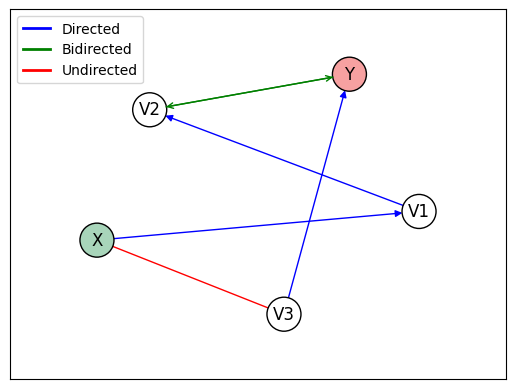

In [18]:
# AG
draw_mixed_graph(AG, inend=({"X"}, {"Y"}))

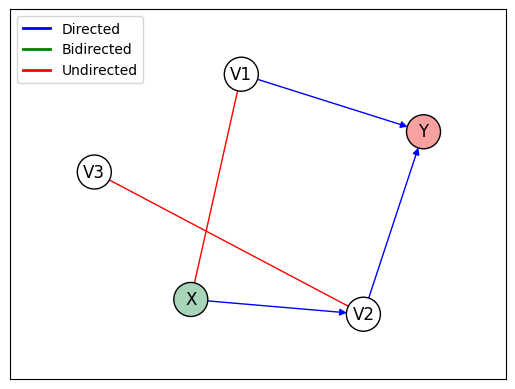

In [20]:
# CPDAG
draw_mixed_graph(CPDAG, inend=({"X"}, {"Y"}))

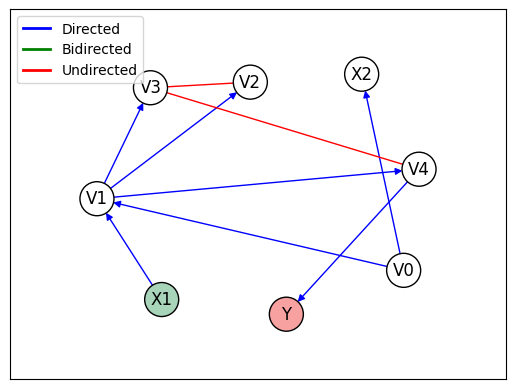

In [23]:
# RCG
draw_mixed_graph(RCG, inend=({"X1"}, {"Y"}))

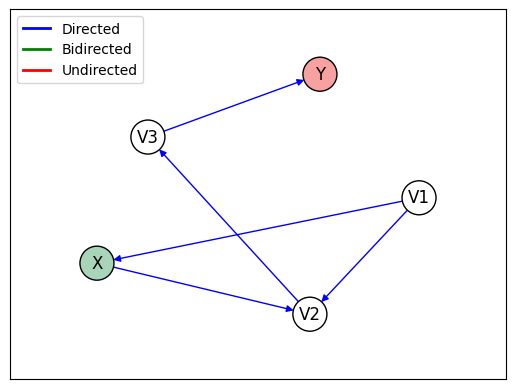

In [24]:
# DAG G1
draw_mixed_graph(G1_new, inend=({"X"}, {"Y"}))

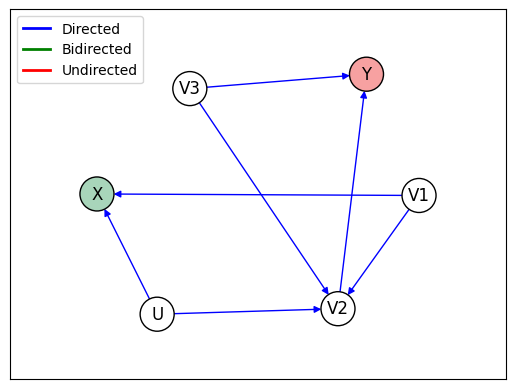

In [29]:
# DAG G2
draw_mixed_graph(G2_new, inend=({"X"}, {"Y"}))

##### Algorithm

In a similar manner to the DAG algorithm, we need to calculate the ancestoral set. For a general algorithm graphs we calculate the anterior - set of possible ancestors. Definition: If there is a possibly directed path from V to W, V is a possible ancestor of W and W is a possible descendant of V. A path (sequence of adjacent nodes in which no node occurs twice) is possibly directed, if every edge is undirected or directed and pointing away from the start node.

In [75]:
def possible_ancestors(G: pg.networkx.MixedEdgeGraph, S: Set[str]) -> Set[str]:
    """
    Compute the set of possible ancestors (pAn) in a mixed-edge graph for a given set of nodes S.

    Parameters:
      G (MixedEdgeGraph): A pywhy MixedEdgeGraph.
      S (Set[str]): A set of nodes in the graph.

    Returns:
      Set[str]: The set of possible ancestors (pAn) of the nodes in S.
    """

    pAn = set()
    all_nodes = set(G.nodes)
    queue = list(S) # set S is in the queue

    # iterate while there are nodes to process in the queue
    while queue:
        current_node = queue.pop(0)
        for neighbor in G.neighbors(current_node):
          for edge_type in G.edge_types:
            # the paper states that for AGs for any edge A ← B or A ↔ B, A is not an anterior of B.
            # RCGs do not have biderectional edges, so this function works for them as well
            # has_edge(N, C=current_node, directed) will give true only for an edge C <- N
            if G.has_edge(neighbor, current_node, edge_type=edge_type) and neighbor not in pAn and edge_type != 'bidirected':
              pAn.add(neighbor)
              queue.append(neighbor)
    return pAn

Now we need to define a more general closure calculation. First we need to define modified Bayes-Ball rules for all types of edge combinations.

In [77]:
# bi is biderected, un is undirected
def bayess_ball_pass_mixed(e, V, f, N, A, Z):
    """
    Determines whether the Bayes Ball can pass through a given node in a mixed graph.

    Parameters:
        e (str): The direction of the entering edge ("in", "out", "bi", "un").
        V (str): The current node being evaluated.
        f (str): The direction of the exiting edge relative to the neighbour ("in", "out", "bi", "un").
        N (str): The neighbor node of V.
        A (Set[str]): The set of nodes that restrict Bayes Ball movement,
        the ball cannot pass to nodes outside this set.
        Z (Set[str]): The separator.

    Returns:
        bool: True if the Bayes Ball can pass, False otherwise.
    """

    in_a = N in A
    V_not_in_Z = V not in Z

    # define allowed edge combinations based on V's presence in Z
    if V_not_in_Z:
        # combinations allowed if V is not in Z
        valid_combinations = {
            ("in", "in"), ("in", "out"), ("in", "bi"),
            ("out", "in"), ("out", "out"), ("out", "bi"), ("out", "un"),
            ("bi", "in"), ("bi", "out"), ("bi", "bi"),
            ("un", "in"), ("un", "un")
        }
    else:
        # combinations allowed if V is in Z
        valid_combinations = {
            ("in", "out"), ("in", "bi"),
            ("bi", "out"), ("bi", "bi")
        }
    return in_a and (e, f) in valid_combinations


Now there is not much left to do to define new reachable function. The function is already capable of dealing with potential cycles, because we have (f, N) not in P check that prevent us from revisiting nodes.

In [78]:
def reachable(G: pg.networkx.MixedEdgeGraph, X: Set[str] = set(),
                 A: Set[str] = set(), Z: Set[str] = set()):
  """
  Computes nodes W in V that are reachable from a set of nodes X
  by an almost definite status walk on which all noncolliders are not in Z and restricted to nodes in A.
  We will call this set the closure as well.

  Parameters:
      G (MixedEdgeGraph): A pywhy MixedEdgeGraph.
      X (Set[str]): The set of nodes the closure of which is calculated.
      A (Set[str]): The set of nodes that restrict the closure,
      the closure cannot have nodes outside this set.
      Z (Set[str]): The separator.

  Returns:
      Set[str]: Closure of X.
  """

  # define the queue of pairs (type of edge, node) to visit.
  Q = deque([])


  # access directed graph inside the mixed one
  directed_graph = G.get_graphs()['directed']

  for node in X:
      Q.append(("out", node)) # we take edge "out" out since it allows traversal through X in any case

  P = Q.copy()
  while any(Q):
    e, V = Q.popleft()
    # find neighbours of V and their edge types.
    edge_node_pairs = []
    for N in G.neighbors(V):
        if G.has_edge(V, N, edge_type='directed'):
            edge_node_pairs.append(("in", N))
        elif G.has_edge(N, V, edge_type='directed'):
            edge_node_pairs.append(("out", N))
        elif G.has_edge(V, N, edge_type='bidirected'):
            edge_node_pairs.append(('bi', N))
        elif G.has_edge(V, N, edge_type='undirected'):
            edge_node_pairs.append(('un', N))
    for f, N in edge_node_pairs:
        # if the Bayess ball can pass to the neighbour, add it to the queue.
        # here it is very important that the way we assign e and f is consistent
        # with the way the are processed by Bayess Ball function
        if (f, N) not in P and bayess_ball_pass_mixed(e=e, V=V, f=f, N=N, A=A, Z=Z):
            Q.append((f, N))
            P.append((f, N))

  return {w for (_, w) in P}

In [79]:
reachable(CPDAG, {"X"}, A=possible_ancestors(CPDAG, {"X", "Y"})|{"X", "Y"}, Z={"V2"})

{'V1', 'V2', 'X', 'Y'}

Let's define the function to test if a given separator is minimal.

In [101]:
def test_min_sep(G: pg.networkx.MixedEdgeGraph, X: Set[str] = set(), Y: Set[str] = set(),
                    I: Set[str] = set(), notR: Set[str] = set(), Z: Set[str] = set()):
    """
    Tests if a set Z is a minimal separator for sets X and Y in graph G.

    Parameters:
        G (pg.networkx.MixedEdgeGraph): A pywhy MixedEdgeGraph.
        X (Set[str]) and Y (Set[str]): The sets of nodes to be separated.
        I (Set[str]): Nodes that must always be included in the separator.
        notR (Set[str]): Nodes that must not be included in the separator.
        Z (Set[str]): The separator to test.

    Returns:
        True if Z is a minimal separator, False otherwise
    """

    R = set(G.nodes) - notR # nodes allowed to be in a separator

    # check for default constraints
    if not (I <= Z) or not (Z <= R):
        return False

    XYI = X | Y | I
    A = possible_ancestors(G, XYI) | XYI

    # Z should contain nodes only from A
    if not (Z <= A):
        return False

    # check if Z a separator
    X_closure = reachable(G, X, A=A, Z=Z)
    if X_closure & Y:
        return False

    # if some node Z/I is not reachable from X, it is unnecessary
    if not (Z - I <= X_closure):
        return False

    # same for Y
    Y_closure = reachable(G, Y, A=A, Z=Z)
    if not (Z - I <= Y_closure):
        return False

    # if all conditions are satisfied, Z is a minimal separator
    return True

Let's test for DAG examples from the paper. When we implement all the algorithms, we will check this function for other graphs as well.

In [102]:
test_min_sep(G1_new, X={"X"}, Y={"Y"}, Z={"V3"})

True

In [103]:
test_min_sep(G1_new, X={"X"}, Y={"Y"}, Z={"V3", "V2"})

False

In [104]:
test_min_sep(G2_new, X={"X"}, Y={"Y"}, Z={"V2", "V3"}, notR={"U"})

True

In [105]:
test_min_sep(G2_new, X={"X"}, Y={"Y"}, Z={"V2", "V3", "V1"}, notR={"U"})

False

Final steps. The FINDNEARESTSEP look for separators that are nearest to one of the sets and satisfy constraints.

In [85]:
def find_nearest_sep(G: pg.networkx.MixedEdgeGraph, X: Set[str], Y: Set[str],  I: Set[str] = set(), notR: Set[str] = set()) -> Set[str]:
    """
    Finds a nearest separator for sets X and Y in graph G.

    Parameters:
        G (pg.networkx.MixedEdgeGraph): A pywhy MixedEdgeGraph.
        X (Set[str]) and Y (Set[str]): The set of nodes to be separated.
        I (Set[str]): Nodes that must always be included in the separator.
        notR (Set[str]): Nodes that must not be included in the separator.

    Returns:
        A nearest separator set if it exists, otherwise None.
    """
    R = set(G.nodes) - notR # nodes allowed to be in a separator
    XYI = X | Y | I
    A = possible_ancestors(G, XYI) | XYI

    Z0 = R & (A - (X | Y))
    X_closure = reachable(G, X, A=A, Z=Z0)

    # check if Z0 is a separator
    if X_closure & Y:
        return None
    # only keep nodes that are reachable from X (and I by default)
    return (Z0 & X_closure) | I

In [86]:
def find_min_sep(G: pg.networkx.MixedEdgeGraph, X: Set[str], Y: Set[str],  I: Set[str] = set(), notR: Set[str] = set()) -> Set[str]:
    """
    Finds a minimal separator for sets X and Y in graph G.

    Parameters:
        G (pg.networkx.MixedEdgeGraph): A pywhy MixedEdgeGraph.
        X (Set[str]) and Y (Set[str]): The set of nodes to be separated.
        I (Set[str]): Nodes that must always be included in the separator.
        notR (Set[str]): Nodes that must not be included in the separator.

    Returns:
        A minimal separator set if it exists, otherwise None.
    """
    # find separators nearest to X or Y
    ZX = find_nearest_sep(G, X, Y, I, notR)
    if ZX is None:
      return None
    ZY = find_nearest_sep(G, Y, X, I, set(G.nodes) - ZX)
    # if both are empty, return None
    if ZY is None:
      return None

    return (ZY & ZX) | I

##### Tests

Minimal d-separator:  {'V2'}


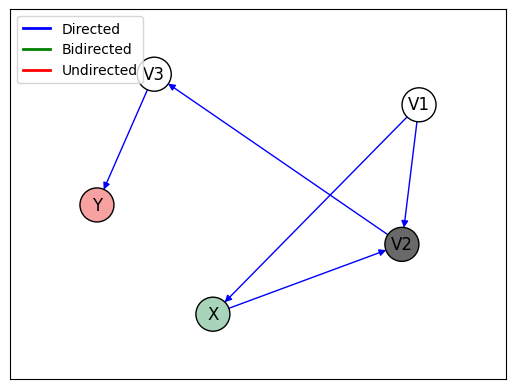

In [90]:
start_nodes = {"X"}
end_nodes = {"Y"}
minsepG1 = find_min_sep(G1_new, {"X"}, {"Y"})
print("Minimal d-separator: ", minsepG1)
draw_mixed_graph(G1_new, inend=(start_nodes, end_nodes), Z=minsepG1)

Minimal d-separator:  {'V2', 'V3'}


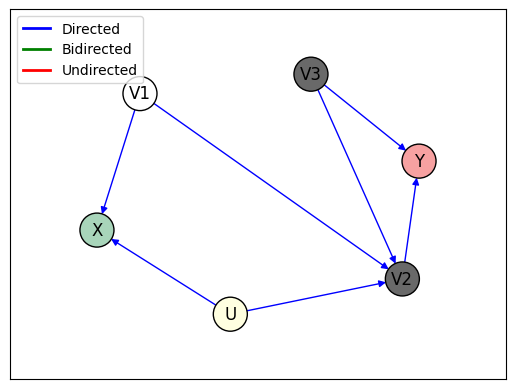

In [91]:
start_nodes = {"X"}
end_nodes = {"Y"}
unobs = {"U"}
minsepG2 = find_min_sep(G2_new, X=start_nodes, Y=end_nodes, notR=unobs)
print("Minimal d-separator: ", minsepG2)
draw_mixed_graph(G2_new, inend=(start_nodes, end_nodes), unobs=unobs, Z=minsepG2)

The results for DAGs are consistent with a DAG algorithm and the results in the paper.

Minimal separator:  {'V3'}


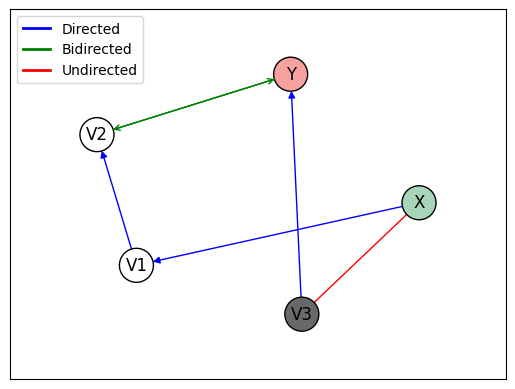

In [106]:
start_nodes = {"X"}
end_nodes = {"Y"}
minsepAG = find_min_sep(AG, X=start_nodes, Y=end_nodes)
print("Minimal separator: ", minsepAG)
draw_mixed_graph(AG, inend=(start_nodes, end_nodes), Z=minsepAG)

In [107]:
test_min_sep(AG, {"X"}, {"Y"}, Z=minsepAG)

True

In [109]:
test_min_sep(AG, {"X"}, {"Y"}, Z={"V2", "V3"})

False

Indeed if we take V3 out of Z, then we can pass X - V3 -> Y. The path X -> V1 -> V2 <-> Y is blocked since V2 is a collider not in Z. The minimal separator is defined correctly. Now let's conduct last tests for the RCG and CPDAG.

Minimal d-separator:  {'V1'}


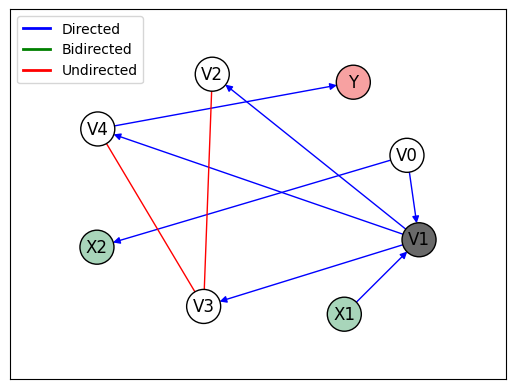

In [126]:
start_nodes = {"X1", "X2"}
end_nodes = {"Y"}
minsepRCG = find_min_sep(RCG, X=start_nodes, Y=end_nodes)
print("Minimal d-separator: ", minsepRCG)
draw_mixed_graph(RCG, inend=(start_nodes, end_nodes), Z=minsepRCG)

In [127]:
test_min_sep(RCG, {"X1", "X2"}, {"Y"}, Z=minsepRCG)

True

In [128]:
test_min_sep(RCG, {"X1", "X2"}, {"Y"}, Z={"V2"})

False

V1 is minimal separator between X1, X2 and Y.

Minimal d-separator:  {'V2', 'V1'}


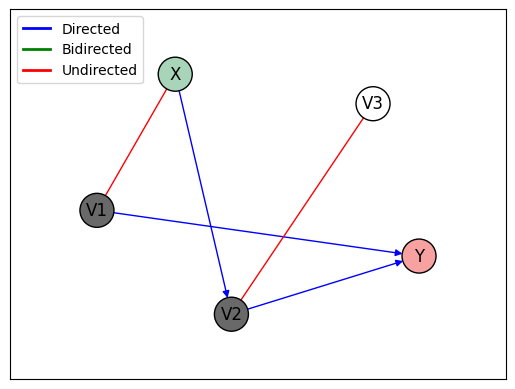

In [129]:
start_nodes = {"X"}
end_nodes = {"Y"}
minsepCPDAG = find_min_sep(CPDAG, X=start_nodes, Y=end_nodes)
print("Minimal d-separator: ", minsepCPDAG)
draw_mixed_graph(CPDAG, inend=(start_nodes, end_nodes), Z=minsepCPDAG)

In [130]:
test_min_sep(CPDAG, {"X"}, {"Y"}, Z=minsepCPDAG)

True

In [131]:
test_min_sep(CPDAG, {"X"}, {"Y"}, Z={"V1"})

False

In [132]:
test_min_sep(CPDAG, {"X"}, {"Y"}, Z={"V1", "V2", "V3"})

False

The algorithm passes all the test both from the paper and the ones made by us.